Checklist

 - dummy features
 - scale standardization
 - train/test splits

Understand the importance of creating a model training development data set.
● Correctly identify when to create dummy features or one-hot encoded features.
● Understand the importance of magnitude standardization.
● Apply the train and test split to the development dataset effectively.


----

<font color="green">Feature selection, model family assessment, randomsearch iterations and inital parameter constraints</font>
 - nominated Ridge, GradientBoosting, ExtraTrees, XGBs from initial assessment
 - nominated Ridge, GradientBoosting, XGBs from RandomSearch iteration determination
   - Ridge: 150 iterations, saga `solver`. vary `alpha` and `tolerance`
   - GB: 60?90? iterations, huber `loss` function, vary `n_estimators` and `learning_rate`
     - should repeat exercise with proper cv score reporting
     - drop nan from gradientboosting
   - XGB: 45 for gblinear, 60 for gbtree
 - final scoring: default + tuned with determined RSCV iterations
   - drop GradientBoosting due to fit time

<font color="red">Fix scoring and re-run ensmeble methods RandomSearchCV iteration determination overnight</font>


<font color="red">Bayesian Methods / optimization???</font>
 - https://www.pymc.io/projects/docs/en/stable/learn.html

In [1]:
from time import time
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression,  f_classif
from sklearn.linear_model import LinearRegression, Ridge,  Lasso, SGDRegressor,  LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline

import xgboost as xgb

### Load Data
- add dummy features for demonstration
- train / test / validate split
- standardize

In [2]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
data.shape

(1521, 20)

#### Dummy Features
Create `game_type`, to describe game. *need to load dataset with `week` column*
 - regular = regular season game
 - playoffs = playoff game
 - demo = all star game or similar
 
Could now one-hot-encode this feature for use in models. I will retain this feature for labelling results.
 
~~Create `season`, to describe year of play~~

In [67]:
d = pd.read_parquet(Path('data/clean_1/game_stats_2023-09-19.parquet'))
d = d.loc[data.index,'week']
d = d.astype(str)
d.unique()

array(['1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', 'championship', '4', 'playoffs', '16', '17',
       'allstars', 'divisional-champ', 'semi-finals'], dtype=object)

In [68]:
data.loc[d[d=='allstars'].index,'game_type'] = 'demo'

In [69]:
reg_weeks = [str(i+1) for i in range(17)]
data.loc[d[d.isin(reg_weeks)].index,'game_type'] = 'regular'

In [70]:
data.loc[data[data.game_type.isna()].index, 'game_type'] = 'playoffs'

In [71]:
data.game_type.value_counts()

game_type
regular     1435
playoffs      85
demo           1
Name: count, dtype: int64

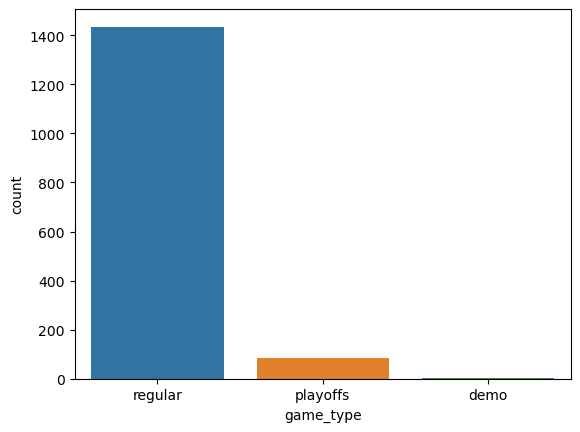

In [72]:
sns.countplot(data, x='game_type')
plt.show()

In [73]:
game_type = data.game_type
data.drop(columns='game_type', inplace=True)

#### Splits, Scaling

In [3]:
data.iloc[:,6:-2]

,home_completions,away_completions,home_throws,away_throws,home_blocks,away_blocks,home_turnovers,away_turnovers,home_completion_rate,away_completion_rate,comp_rate_diff,block_turnover_diff
1893,189,180,211,190,18,13,24,28,0.895735,0.947368,-0.051634,9
1892,108,176,125,189,10,15,21,29,0.864000,0.931217,-0.067217,3
1896,162,144,175,158,10,6,26,26,0.925714,0.911392,0.014322,4
1897,127,197,142,203,13,11,23,34,0.894366,0.970443,-0.076077,13
1899,182,114,195,130,14,10,31,20,0.933333,0.876923,0.056410,-7
...,...,...,...,...,...,...,...,...,...,...,...,...
3228,210,323,227,344,10,12,17,21,0.925110,0.938953,-0.013843,2
3229,290,267,294,277,3,3,4,10,0.986395,0.963899,0.022496,6
3230,259,191,276,219,13,7,17,28,0.938406,0.872146,0.066260,17
3231,330,221,348,241,13,12,18,20,0.948276,0.917012,0.031263,3


In [3]:
X = data.iloc[:,6:-2]
y1 = data['home_margin'] # target for regression
y2 = data['home_win'] # target for classification

In [4]:
# Initial Split, this test set will be hold out for scoring
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2)
y2_train = y2[y1_train.index]
y2_test = y2[y1_test.index]
features = X_train.columns
print(X_train.shape)
print(X_test.shape)

(1216, 12)
(305, 12)


In [5]:
# Scale data, fit scaler to training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression for target: `home_margin`
 - basic grid search for feature selection `SelectKBest`
   - **finding: will select 6 best features in regression model pipelines**
 - Loop through model types to nominate final model(s) for tuning
   - within loop, RandomizedSearch to tune hyperparameters
 - score models with test set

#### Feature Selection - SelectKBest
 - `5` or `6` features best for linear models, `6` maintains home/away balance
 - **CV Folds**
   - `3,4,5,6`
   - *May be best to repeat procedure with final data split for model training*

In [17]:
kbest_margin = SelectKBest(score_func=f_regression, k='all')
kbest_margin.fit(X_train,y1_train)
pd.DataFrame(kbest_margin.scores_,index=features).sort_values(0,ascending=False)

,0
block_turnover_diff,5365.638968
comp_rate_diff,500.152092
home_blocks,443.034569
away_turnovers,370.277631
away_blocks,267.873639
home_turnovers,203.948289
away_completion_rate,136.225836
home_completion_rate,109.496957
home_throws,2.954390
away_throws,2.407834


In [18]:
kbest_win = SelectKBest(score_func=f_classif, k='all')
kbest_win.fit(X_train,y1_train)
pd.DataFrame(kbest_win.scores_,index=features).sort_values(0,ascending=False)

,0
block_turnover_diff,116.305203
comp_rate_diff,11.810305
home_blocks,11.253440
away_turnovers,10.289040
away_blocks,7.587433
home_turnovers,6.952988
away_completion_rate,5.073693
home_completion_rate,3.914244
away_completions,1.819483
away_throws,1.794623


In [42]:
ks = [val+1 for val in range(12)]
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=12), LinearRegression())
grid_params = {
    'selectkbest__k': ks,
    'linearregression__positive': [False, True]
}

In [43]:
cv = GridSearchCV(kb_pipe, param_grid=grid_params, cv=5,
                  scoring='neg_root_mean_squared_error', 
                  n_jobs=-1,)

In [44]:
%%time
cv.fit(X_train,y1_train)

CPU times: total: 281 ms
Wall time: 272 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(k=12,
                                                    score_func=<function f_regression at 0x0000021307AF0F70>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__positive': [False, True],
                         'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12]},
             scoring='neg_root_mean_squared_error')

In [45]:
results = pd.DataFrame(cv.cv_results_)  

C:\Users\Nish\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


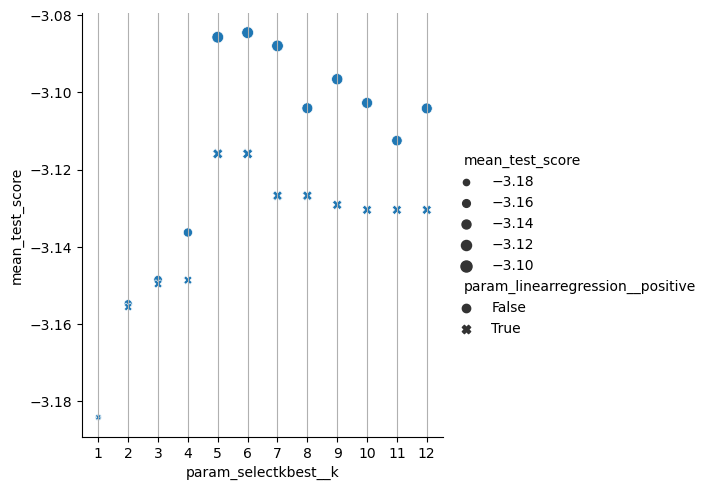

In [46]:
sns.relplot(results, x='param_selectkbest__k', y='mean_test_score', 
            style='param_linearregression__positive', size='mean_test_score')
plt.grid(axis='x')
plt.xticks(ks)
plt.show()

C:\Users\Nish\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


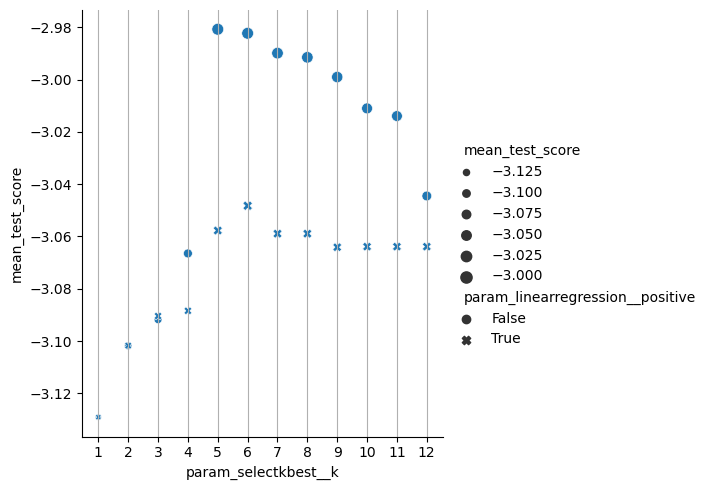

In [15]:
sns.relplot(results, x='param_selectkbest__k', y='mean_test_score', 
            style='param_linearregression__positive', size='mean_test_score')
plt.grid(axis='x')
plt.xticks(ks)
plt.show()

In [11]:
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=5), LinearRegression())
for folds in [3,4,5,6,8,10,12]:
    scores = cross_validate(kb_pipe, X_train, y1_train, cv=folds)['test_score']
    print(folds, round(scores.mean(),3), '±', round(scores.std(),3))

3 0.828 ± 0.01
4 0.826 ± 0.014
5 0.825 ± 0.036
6 0.828 ± 0.038
8 0.825 ± 0.053
10 0.827 ± 0.041
12 0.827 ± 0.051


In [12]:
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=5), LinearRegression())
for folds in [3,4,5,6,8,10,12]:
    scores = cross_validate(kb_pipe, X_train, y1_train, cv=folds)['test_score']
    print(folds, round(scores.mean(),3), '±', round(scores.std(),3))

3 0.828 ± 0.01
4 0.826 ± 0.014
5 0.825 ± 0.036
6 0.828 ± 0.038
8 0.825 ± 0.053
10 0.827 ± 0.041
12 0.827 ± 0.051


#### Model Family Assessment
 - quick cv scoring of a variety of models
 - proceed with:
   - `GradientBoostingRegressor` OR `ExtraTreesRegressor` AND `xgb.XGBRegressor(booster="?")`
     - figure out tuning for XGB later
   - `LinearRegression`, `Ridge` 
     - better performing linear models
   

In [7]:
def_models = {
    'linreg': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SGD': SGDRegressor(),
    'random forest': RandomForestRegressor(),
    'et': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'xgb_linear': xgb.XGBRegressor(booster="gblinear"),
    'xgb_tree': xgb.XGBRegressor(booster="gbtree"),
}

In [8]:
model_scores1 = pd.DataFrame(columns=['cv_score','std','fit_time'])

In [9]:
def model_scoring(name, model):
    if name in ['linreg','Ridge','Lasso','SGD','xgb_linear']:
        cv2 = cross_validate(model, 
                            SelectKBest(f_regression,k=6).fit_transform(X_train,y1_train), 
                            # X_train,
                            y1_train, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error')
        model_scores1.loc[f"{name}_k6", 'cv_score'] = np.mean(cv2['test_score'])
        model_scores1.loc[f"{name}_k6", 'std'] = np.std(cv2['test_score'])
        model_scores1.loc[f"{name}_k6", 'fit_time'] = round(cv2['fit_time'].sum(),2)
        
    cv = cross_validate(model, 
                        # SelectKBest(f_regression,k=6).fit_transform(X_train,y1_train), 
                        X_train,
                        y1_train, 
                        cv=5, 
                        scoring='neg_root_mean_squared_error')        
    
    model_scores1.loc[name, 'cv_score'] = np.mean(cv['test_score'])
    model_scores1.loc[name, 'std'] = np.std(cv['test_score'])
    model_scores1.loc[name, 'fit_time'] = round(cv['fit_time'].sum(),2)

In [11]:
%%time
for name,model in def_models.items():
    model_scoring(name,model)

CPU times: total: 24.1 s
Wall time: 15.7 s


In [12]:
model_scores1.sort_values('cv_score', ascending=False).round(3)

,cv_score,std,fit_time
et,-2.591336,0.231191,3.41
gradient boosting,-2.609459,0.29941,2.57
xgb_tree,-2.678349,0.357102,0.49
random forest,-2.760967,0.223665,8.63
xgb_linear_k6,-2.811519,0.27026,0.07
Ridge_k6,-2.813998,0.289756,0.01
linreg_k6,-2.815333,0.296839,0.06
SGD_k6,-2.819484,0.267853,0.03
linreg,-2.849316,0.399276,0.01
Ridge,-2.851522,0.307439,0.01


In [13]:
model_scores1.sort_values('cv_score', ascending=False).round(3)

,cv_score,std,fit_time
et,-2.730,0.0,3.43
gradient boosting,-2.759,0.0,2.54
linreg,-2.800,0.0,0.06
Ridge,-2.800,0.0,0.02
SGD,-2.806,0.0,0.05
xgb_linear,-2.811,0.0,0.10
random forest,-2.850,0.0,8.65
xgb_tree,-2.866,0.0,0.59
Lasso,-3.139,0.0,0.02


### Tuning Assessment
- tuning decreased RMSE from default models
  - *actual errors will report each time without setting random state*

#### Random Search CV
 - Linear, Ridge and SGD: `Ridge()`
 - Gradient boosting: XGB `xgb.XGBRegressor(booster="gblinear")` and `xgb.XGBRegressor(booster="gbtree")` 
 - Gradient boosting: `GradientBoostingRegressor`
 - Extremely randomized trees: `ExtraTreesRegressor()`
 
**Steps**
  - investigate tuned model scores vs number of randomized search iterations
    - can allow many for linear/faster fitting models
    - **`150` for Ridge regressor**, *using saga solver*
    - **`60` for GradientBoosting Regressor**, *using Huber loss function*
    - XGB
      - **XGB Linear Iterations: `60`**
      - **XGB Tree Iterations: `45`**
      - some parameter constraints determined for both
  - perform RandomizedSearchCV again with determined iterations and other parameter constraints
  - briefly investigate results, repeat tuning for final modeling notebook

##### Iterations for XGB
 - try **linear** and **tree** objective functions
   - [parameters for XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html)
 

In [19]:
def_models = {
    'xgb_linear': xgb.XGBRegressor(booster="gblinear"),
    'xgb_tree': xgb.XGBRegressor(booster="gbtree"),
}

parameters = {
    #lambda (L2), updater, feature_selector. based on RScv could just leave latter at defaults. Try L1 reg
    # defaults: L2=0, updater=shotgun, feature_selector=cyclic
    # stats shape notes: for lambda, could reduce stats.gamma "a" to 0.5ish
    'xgb_linear': {'lambda':stats.gamma(1,0,1), 'updater':['shotgun','coord_descent'], 'feature_selector': ['cyclic','shuffle']},
    # eta/learning_rate, gamma/min_split_loss, max_depth
    # defaults: eta=0.3, gamma=0, max_depth=6, 
    # stats shape notes: for max_depth, could reduce stats.binom 4/0.5,(2 or 1). could increase range for gamma amd eta (3,6 or 4,8)
    'xgb_tree': {'eta':stats.beta(6,12,0,1), 'gamma':stats.uniform(0,2), 'max_depth':stats.binom(10,0.5,1),},
}

In [42]:
%%time

it_search = pd.DataFrame()

its = [10,20,30,45,60,90,120,150,300]
model_name = 'xgb_linear'

for it in tqdm(its):
    start = time()
    search = RandomizedSearchCV(def_models['xgb_linear'], parameters['xgb_linear'], scoring='neg_root_mean_squared_error', n_iter=it)
    search.fit(SelectKBest(score_func=f_regression, k=6).fit_transform(X_train,y1_train), y1_train)

    it_search.loc[it,'iterations'] = it
    it_search.loc[it,'best_score'] = -1*search.best_score_
    it_search.loc[it,'avg_score'] = -1*search.cv_results_['mean_test_score'].mean()
    it_search.loc[it,'std'] = search.cv_results_['mean_test_score'].std()
    it_search.loc[it,'fit_time'] = search.cv_results_['mean_fit_time'].sum()
    it_search.loc[it,'param_lambda'] = search.best_params_['lambda']
    it_search.loc[it,'param_updater'] = search.best_params_['updater']
    it_search.loc[it,'feature_selector'] = search.best_params_['feature_selector']
    it_search.loc[it,'total_time'] = round(time()-start,2)

100%|██████████| 9/9 [01:45<00:00, 11.78s/it]

CPU times: total: 19min 9s
Wall time: 1min 45s


In [43]:
it_search.sort_values('best_score')

,iterations,best_score,avg_score,std,fit_time,param_lambda,param_updater,feature_selector,total_time
60,60.0,2.811436,3.749576,0.609377,1.294657,0.000298,shotgun,cyclic,7.38
300,300.0,2.811542,3.746410,0.672277,6.466326,0.001485,shotgun,shuffle,36.86
20,20.0,2.812295,3.683913,0.595381,0.454216,0.006548,coord_descent,shuffle,2.63
90,90.0,2.812352,3.762315,0.637187,1.968042,0.000769,coord_descent,cyclic,11.26
150,150.0,2.813467,3.766843,0.633607,3.645428,0.007690,coord_descent,cyclic,20.61
10,10.0,2.816827,3.561987,0.587045,0.190246,0.012259,coord_descent,cyclic,1.14
45,45.0,2.823096,3.836646,0.688507,0.996679,0.017844,shotgun,shuffle,5.70
30,30.0,2.845045,3.915419,0.677174,0.690191,0.033030,coord_descent,shuffle,3.96
120,120.0,2.846173,3.751345,0.625407,2.911420,0.033370,shotgun,shuffle,16.44


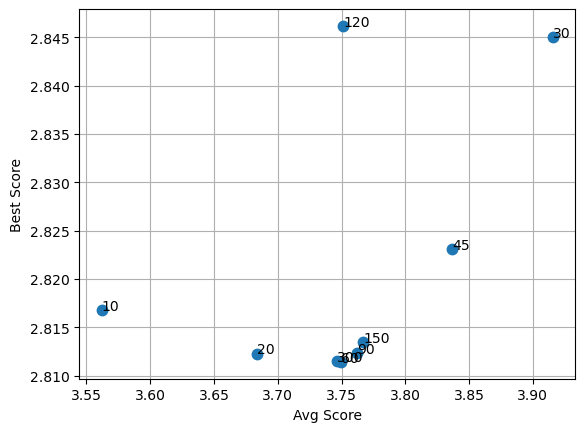

In [44]:
plt.plot(it_search.avg_score, it_search.best_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'avg_score'], it_search.loc[val,'best_score']))
plt.xlabel('Avg Score')
plt.ylabel('Best Score')
plt.grid()
#plt.xlim(20,320)
plt.show()

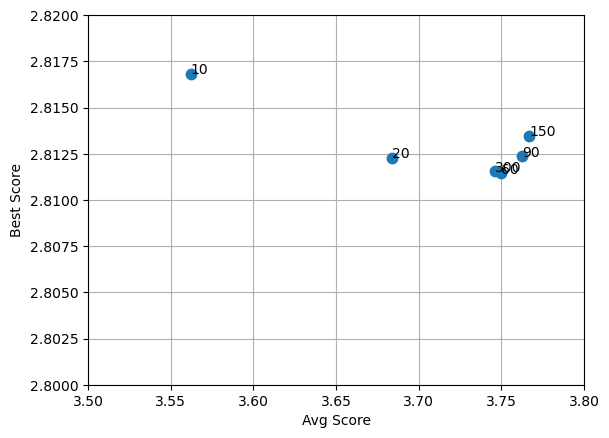

In [48]:
plt.plot(it_search.avg_score, it_search.best_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'avg_score'], it_search.loc[val,'best_score']))
plt.xlabel('Avg Score')
plt.ylabel('Best Score')
plt.grid()
plt.ylim(2.8,2.82)
plt.xlim(3.5,3.8)
plt.show()

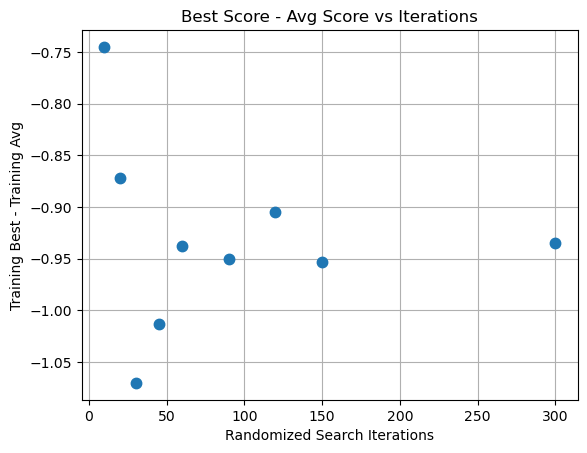

In [45]:
plt.plot(it_search.iterations, it_search.best_score - it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
plt.title('Best Score - Avg Score vs Iterations')
plt.xlabel('Randomized Search Iterations')
plt.ylabel('Training Best - Training Avg')
plt.grid()
#plt.xlim(20,320)
plt.show()

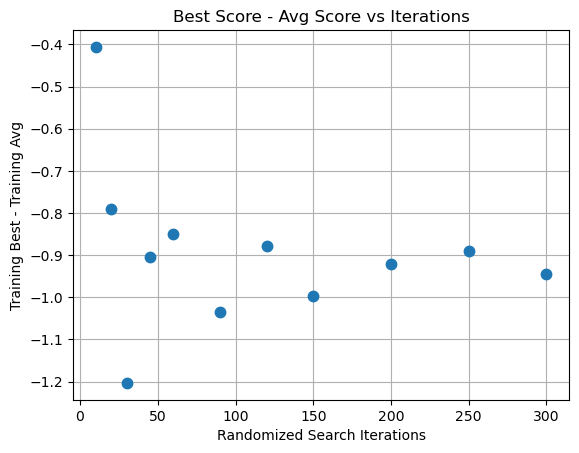

In [28]:
plt.plot(it_search.iterations, it_search.best_score - it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
plt.title('Best Score - Avg Score vs Iterations')
plt.xlabel('Randomized Search Iterations')
plt.ylabel('Training Best - Training Avg')
plt.grid()
#plt.xlim(20,320)
plt.show()

In [49]:
%%time

it_search = pd.DataFrame()

its = [10,20,30,45,60,90,120,150]


for it in tqdm(its):
    start = time()
    search = RandomizedSearchCV(def_models['xgb_tree'], parameters['xgb_tree'], scoring='neg_root_mean_squared_error', n_iter=it)
    search.fit(X_train, y1_train)
    
    it_search.loc[it,'iterations'] = it
    it_search.loc[it,'best_score'] = -1*search.best_score_
    it_search.loc[it,'avg_score'] = -1*search.cv_results_['mean_test_score'].mean()
    it_search.loc[it,'std'] = search.cv_results_['mean_test_score'].std()
    it_search.loc[it,'fit_time'] = search.cv_results_['mean_fit_time'].sum()
    it_search.loc[it,'param_eta'] = search.best_params_['eta']
    it_search.loc[it,'param_gamma'] = search.best_params_['gamma']
    it_search.loc[it,'max_depth'] = search.best_params_['max_depth']
    it_search.loc[it,'total_time'] = round(time()-start,2)

100%|██████████| 8/8 [04:14<00:00, 31.80s/it]

CPU times: total: 47min 15s
Wall time: 4min 14s


In [50]:
it_search.sort_values('best_score')

,iterations,best_score,avg_score,std,fit_time,param_eta,param_gamma,max_depth,total_time
45,45.0,2.471826,2.720931,0.099578,4.086229,0.327596,1.327539,3.0,21.30
90,90.0,2.478425,2.709909,0.109220,7.956355,0.190471,0.952639,3.0,41.45
120,120.0,2.491120,2.729818,0.108852,11.256376,0.331768,0.873865,3.0,58.51
30,30.0,2.509771,2.705981,0.091865,2.813774,0.348085,1.625913,3.0,14.67
150,150.0,2.512243,2.720213,0.101461,14.063652,0.262952,1.702462,3.0,73.11
60,60.0,2.517437,2.715362,0.112340,5.761082,0.234108,1.342021,4.0,29.99
10,10.0,2.562215,2.743183,0.117100,0.898275,0.283366,0.787518,4.0,4.75
20,20.0,2.632783,2.758721,0.095616,2.036567,0.429529,0.220771,4.0,10.62


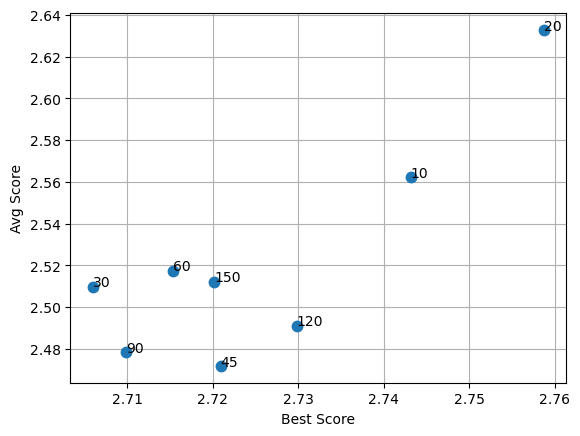

In [52]:
plt.plot(it_search.avg_score, it_search.best_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'avg_score'], it_search.loc[val,'best_score']))
plt.xlabel('Best Score')
plt.ylabel('Avg Score')
plt.grid()
#plt.xlim(20,320)
plt.show()

In [ ]:
plt.plot(it_search.best_score, it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.best_score, it_search.avg_score, yerr=it_search['std']/it_search['std'].max(), linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'best_score'], it_search.loc[val,'avg_score']))
plt.xlabel('best score')
plt.ylabel('avg cv score')
plt.grid()
plt.show()

##### Iterations for Ridge Regression

In [27]:
def_models = {
    'Ridge': Ridge(),
}

parameters = {
    # defaults: alpha=1 [0,inf) | tol=1e-4
    # solvers: skip auto, lbfgs, cholesky. Note that tolerance has no impact for svd
    # 'Ridge': {'alpha': stats.f(10,20,0,1), 'tol':stats.expon(0,5e-4), 'solver':['sparse_cg', 'saga', 'svd', 'lsqr']},
    'Ridge': {'alpha': stats.loguniform(0.001,5050,0,1), 'tol':stats.loguniform(1e-4,1e0,0,1), 'solver':['sparse_cg', 'saga', 'svd', 'lsqr']},
}

In [97]:
%%time

it_search = pd.DataFrame()

its = [10,20,30,45,60,90,120,150,200,250,300]


for it in its:
    start = time()
    search = RandomizedSearchCV(Ridge(), parameters['Ridge'], scoring='neg_root_mean_squared_error', n_iter=it)
    search.fit(SelectKBest(score_func=f_regression, k=6).fit_transform(X_train,y1_train), y1_train)
    it_search.loc[it,'iterations'] = it
    it_search.loc[it,'best_score'] = -1*search.best_score_
    it_search.loc[it,'avg_score'] = -1*search.cv_results_['mean_test_score'].mean()
    it_search.loc[it,'std'] = search.cv_results_['mean_test_score'].std()
    it_search.loc[it,'fit_time'] = search.cv_results_['mean_fit_time'].sum()
    it_search.loc[it,'param_alpha'] = search.best_params_['alpha']
    it_search.loc[it,'param_solver'] = search.best_params_['solver']
    it_search.loc[it,'param_tol'] = search.best_params_['tol']
    it_search.loc[it,'total_time'] = round(time()-start,2)

CPU times: total: 1min 57s
Wall time: 20 s


**Root Mean Squared Error**

In [101]:
it_search.sort_values('avg_score')

,iterations,best_score,avg_score,std,fit_time,param_alpha,param_solver,param_tol,total_time
20,20.0,2.873531,3.037336,0.371955,0.031796,0.003735,saga,0.154430,0.29
150,150.0,2.863185,3.073392,0.424804,0.256022,9.400967,saga,0.191219,2.18
120,120.0,2.870332,3.095678,0.467823,0.206666,0.017227,saga,0.021297,1.81
45,45.0,2.874550,3.106575,0.455696,0.073717,16.502449,svd,0.009312,0.65
250,250.0,2.863166,3.137907,0.566532,0.473367,0.001057,saga,0.239348,4.06
300,300.0,2.856377,3.143705,0.575866,0.585379,0.170850,saga,0.108475,5.17
200,200.0,2.868070,3.153586,0.503934,0.343024,6.683835,saga,0.292491,2.98
90,90.0,2.867545,3.228187,0.633148,0.150498,0.157748,saga,0.044322,1.31
30,30.0,2.874414,3.255455,0.542340,0.051610,14.201430,svd,0.001379,0.46
60,60.0,2.875545,3.322868,0.737504,0.103405,2.192374,svd,0.009590,0.90


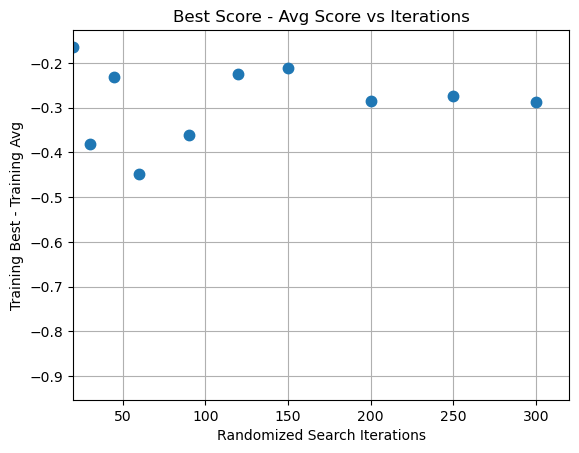

In [99]:
plt.plot(it_search.iterations, it_search.best_score - it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
plt.title('Best Score - Avg Score vs Iterations')
plt.xlabel('Randomized Search Iterations')
plt.ylabel('Training Best - Training Avg')
plt.grid()
plt.xlim(20,320)
plt.show()

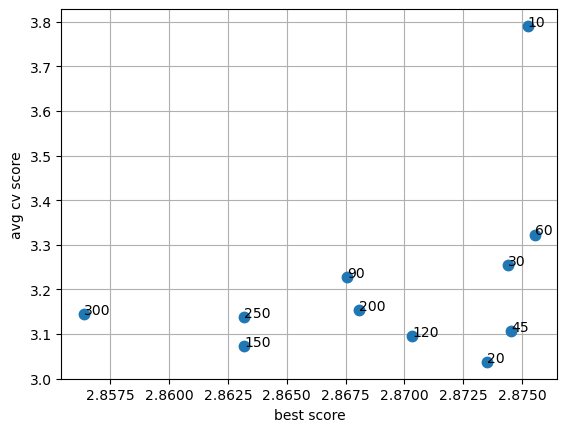

In [100]:
plt.plot(it_search.best_score, it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.best_score, it_search.avg_score, yerr=it_search['std']/it_search['std'].max(), linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'best_score'], it_search.loc[val,'avg_score']))
plt.xlabel('best score')
plt.ylabel('avg cv score')
plt.grid()
plt.show()

**Confirming Default 5-fold CV is good**

In [29]:
%%time

it_search = pd.DataFrame()

its = [10,30,60,120,200]


for it in tqdm(its):
    for folds in [3,4,5,6]:
        start = time()
        search = RandomizedSearchCV(Ridge(), parameters['Ridge'], scoring='neg_root_mean_squared_error', n_iter=it, cv=folds)
        search.fit(SelectKBest(score_func=f_regression, k=6).fit_transform(X_train,y1_train), y1_train)
        
        ind = f"{it}_{folds}"
        
        it_search.loc[ind,'iterations'] = it
        it_search.loc[ind,'folds'] = folds
        it_search.loc[ind,'best_score'] = -1*search.best_score_
        it_search.loc[ind,'avg_score'] = -1*search.cv_results_['mean_test_score'].mean()
        it_search.loc[ind,'std'] = search.cv_results_['mean_test_score'].std()
        it_search.loc[ind,'fit_time'] = search.cv_results_['mean_fit_time'].sum()
        it_search.loc[ind,'param_alpha'] = search.best_params_['alpha']
        it_search.loc[ind,'param_solver'] = search.best_params_['solver']
        it_search.loc[ind,'param_tol'] = search.best_params_['tol']
        it_search.loc[ind,'total_time'] = round(time()-start,2)

100%|██████████| 5/5 [00:19<00:00,  3.99s/it]

CPU times: total: 1min 58s
Wall time: 19.9 s


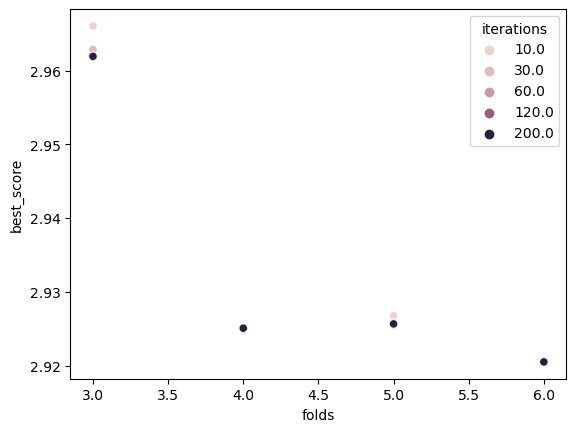

In [40]:
sns.scatterplot(it_search, x='folds', y='best_score', hue='iterations')
plt.show()

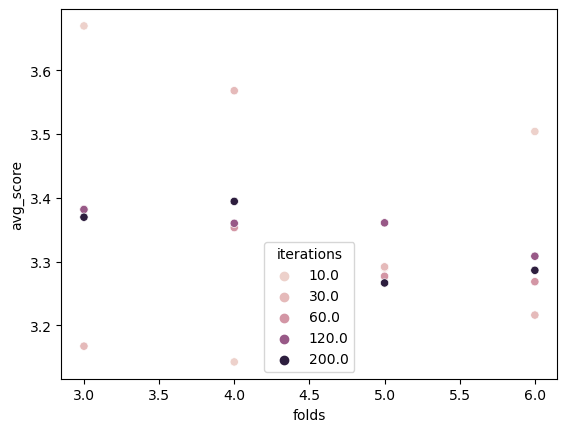

In [41]:
sns.scatterplot(it_search, x='folds', y='avg_score', hue='iterations')
plt.show()

**Mean Squared Error**

In [34]:
it_search.sort_values('avg_score')

,iterations,best_score,avg_score,std,fit_time,param_alpha,param_solver,param_tol,total_time
150,150.0,8.267627,9.975034,4.160541,0.234055,0.002504,saga,0.404941,1.98
90,90.0,8.298822,10.090535,4.157099,0.146432,3.929989,saga,0.007351,1.26
60,60.0,8.287628,10.212395,4.169853,0.097694,0.073421,saga,0.026756,0.81
200,200.0,8.159263,10.257491,4.009451,0.277250,0.002131,saga,0.175602,2.60
250,250.0,8.219020,10.316823,4.542866,0.361258,0.012368,saga,0.218118,3.25
120,120.0,8.285375,10.366692,3.927314,0.202248,0.006623,saga,0.020186,1.79
30,30.0,8.314362,10.424153,5.410059,0.050891,32.576223,saga,0.041740,0.40
300,300.0,8.234880,10.459980,4.553187,0.430348,0.016780,saga,0.307027,3.81
10,10.0,8.324585,10.964617,3.673800,0.015084,0.014825,saga,0.002789,0.14


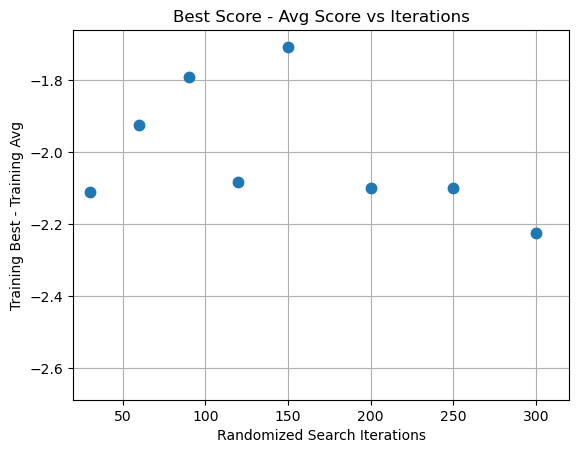

In [35]:
plt.plot(it_search.iterations, it_search.best_score - it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
plt.title('Best Score - Avg Score vs Iterations')
plt.xlabel('Randomized Search Iterations')
plt.ylabel('Training Best - Training Avg')
plt.grid()
plt.xlim(20,320)
plt.show()

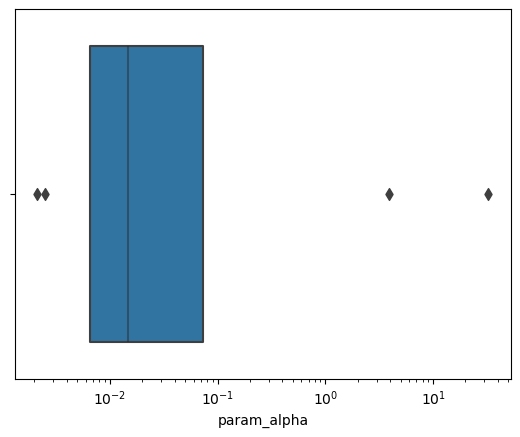

In [57]:
sns.boxenplot(x = it_search.param_alpha)
plt.xscale('log')

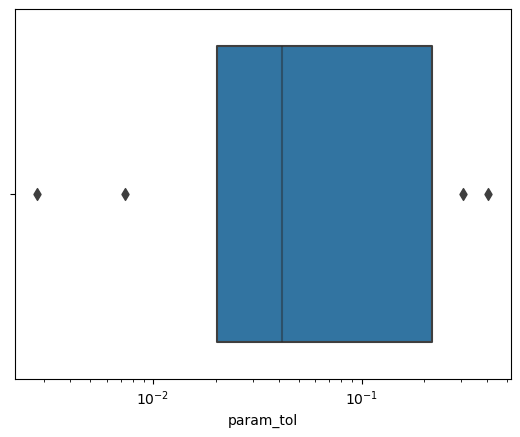

In [58]:
sns.boxenplot(x = it_search.param_tol)
plt.xscale('log')

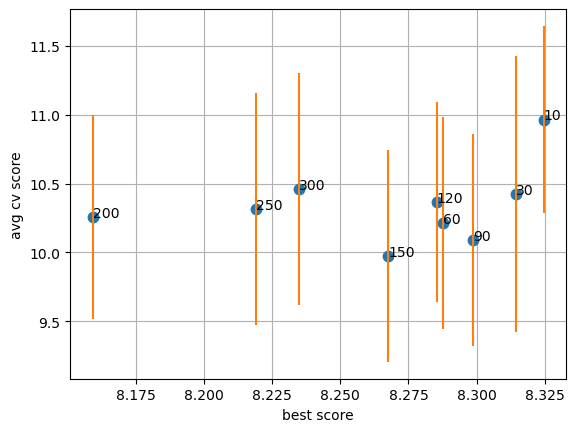

In [49]:
plt.plot(it_search.best_score, it_search.avg_score, '.', markersize=15)
plt.errorbar(it_search.best_score, it_search.avg_score, yerr=it_search['std']/it_search['std'].max(), linestyle='')
for val in it_search.index:
    plt.annotate(val, (it_search.loc[val,'best_score'], it_search.loc[val,'avg_score']))
plt.xlabel('best score')
plt.ylabel('avg cv score')
plt.grid()
plt.show()

##### Iterations for Ensemble Methods
 - **GradientBoostingRegressor**: *prioritize solvable parameters that aren't too long to fit, less likely to overfit*
 - **XGB GB Trees**: see [parameters](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster), figure out how to tune with random search
   - [demo for xgboost with sklearn](https://xgboost.readthedocs.io/en/stable/python/examples/sklearn_parallel.html#sphx-glr-python-examples-sklearn-parallel-py), shows grid search with xgb model

*Testing scoring for CV with GradientBooster*

 - failed fits (overflow error) result in `nan` scores, which should be dropped before computing mean
   - use `nanmean`, `nanstd`
   - load `search.cv_results_` into DataFrame and dropna
     - then calculate mean, sd
     - report successful fits / total

In [ ]:
ensemble_models = {
    'gradient boosting': GradientBoostingRegressor(),
}

parameters = {
    'gradient boosting': {'learning_rate':stats.loguniform(1e-4,1e2,0,1),'n_estimators':stats.boltzmann(3e-3,1e3,1), 
                          'loss':['squared_error','absolute_error','huber']} ,
}

its = [10,20,30]

In [22]:
it_search

,iterations,model,best_score,avg_score,std,fit_time,estimators,rate_or_features,split_or_loss_function,total_time
gradient boosting_10,10.0,gradient boosting,7.670202,5.409897e+181,inf,21.734991,822.0,0.081998,huber,115.63
gradient boosting_20,20.0,gradient boosting,7.742105,2.472400e+223,inf,26.986622,706.0,0.049718,squared_error,139.30
gradient boosting_30,30.0,gradient boosting,7.480147,inf,NaN,36.216450,169.0,0.087337,huber,182.87


In [28]:
pd.DataFrame(search.cv_results_).dropna()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.029618,0.006771,0.001400,4.902743e-04,0.000185,squared_error,202,"{'learning_rate': 0.00018544300261018958, 'los...",-4.501412e+01,-5.084273e+01,-5.407763e+01,-5.904574e+01,-5.396141e+01,-5.258832e+01,4.609062e+00,17
2,0.371658,0.001239,0.001000,7.893059e-07,0.000471,squared_error,72,"{'learning_rate': 0.0004705735983154732, 'loss...",-4.527913e+01,-5.112125e+01,-5.437767e+01,-5.935722e+01,-5.426153e+01,-5.287936e+01,4.625418e+00,18
3,0.115304,0.001113,0.000801,4.003305e-04,34.171357,huber,15,"{'learning_rate': 34.17135689123147, 'loss': '...",-1.823443e+47,-1.936647e+47,-1.946026e+47,-1.815981e+47,-1.731489e+47,-1.850717e+47,8.078806e+45,21
4,0.465390,0.002193,0.001199,4.012609e-04,0.00017,huber,61,"{'learning_rate': 0.00017031769755030107, 'los...",-4.699760e+01,-5.311949e+01,-5.719132e+01,-6.172728e+01,-5.691841e+01,-5.519082e+01,4.922017e+00,19
5,1.228716,0.008032,0.001799,3.993543e-04,0.087337,huber,169,"{'learning_rate': 0.0873370145770669, 'loss': ...",-6.160050e+00,-7.850574e+00,-1.056597e+01,-6.995247e+00,-5.828893e+00,-7.480147e+00,1.694930e+00,1
8,0.246861,0.001190,0.001000,8.529922e-07,4.352834,squared_error,48,"{'learning_rate': 4.352833958222007, 'loss': '...",-1.170452e+52,-1.175190e+52,-1.348799e+52,-1.252705e+52,-1.210152e+52,-1.231460e+52,6.566887e+50,22
9,2.838247,0.020473,0.002800,3.996415e-04,0.243825,squared_error,581,"{'learning_rate': 0.24382469700262444, 'loss':...",-6.495597e+00,-9.526211e+00,-1.170821e+01,-7.973162e+00,-6.893725e+00,-8.519381e+00,1.908882e+00,7
11,0.011599,0.000490,0.000801,4.003544e-04,0.025166,squared_error,2,"{'learning_rate': 0.025165993461148284, 'loss'...",-4.402933e+01,-4.980083e+01,-5.296806e+01,-5.787826e+01,-5.286151e+01,-5.150760e+01,4.547284e+00,16
14,1.196787,0.008687,0.001400,4.894743e-04,0.001062,huber,157,"{'learning_rate': 0.0010621644280076844, 'loss...",-3.648436e+01,-4.156216e+01,-4.544378e+01,-4.928599e+01,-4.527787e+01,-4.361083e+01,4.320412e+00,14
15,1.028008,0.010920,0.001798,3.992340e-04,0.455859,squared_error,210,"{'learning_rate': 0.4558593782567772, 'loss': ...",-6.320487e+00,-1.091581e+01,-1.093937e+01,-7.682349e+00,-6.288901e+00,-8.429383e+00,2.100929e+00,6


In [20]:
ensemble_models = {
    'gradient boosting': GradientBoostingRegressor(),
    'extra trees': ExtraTreesRegressor(),
}

parameters = {
    # eliminate loss function tuning depending on first results, discrete distributions needed for n_estimators
    # defaults: loss=squared_error, learning_rate=0.1, n_estimators=100
    'gradient boosting': {'learning_rate':stats.loguniform(1e-4,1e2,0,1),'n_estimators':stats.boltzmann(3e-3,1e3,1), 
                          'loss':['squared_error','absolute_error','huber']} ,
    # guide suggests tuning n_estimators and max_features
    # defaults: n_estimators=100, criterion=squared_error, max_depth=None, max_features=1
    'extra trees': {'n_estimators':stats.boltzmann(3e-3,1e3,1),'max_features':stats.randint(0,12,1), 
                    'criterion':['squared_error','absolute_error','friedman_mse']}
}

In [21]:
%%time

it_search = pd.DataFrame()

# its = [10,20,30,45,60,90,120,150]
its = [10,20,30]

for name,model in tqdm(ensemble_models.items()):
    for it in tqdm(its):
        start = time()
        search = RandomizedSearchCV(model, parameters[name], scoring='neg_root_mean_squared_error', n_iter=it)
        search.fit(X_train, y1_train)
        ind = f"{name}_{it}"
        
        it_search.loc[ind,'iterations'] = it
        it_search.loc[ind,'model'] = name
        
        it_search.loc[ind,'best_score'] = -1*search.best_score_
        # it_search.loc[ind,'avg_score'] = -1*search.cv_results_['mean_test_score'].mean()
        # it_search.loc[ind,'std'] = search.cv_results_['mean_test_score'].std()
        it_search.loc[ind,'avg_score'] = -1*np.nanmean(search.cv_results_['mean_test_score'])
        it_search.loc[ind,'std'] = np.nanstd(search.cv_results_['mean_test_score'])
        it_search.loc[ind,'fit_time'] = search.cv_results_['mean_fit_time'].sum()
        
        it_search.loc[ind,'estimators'] = search.best_params_['n_estimators']
        if name == 'gradient boosting':
            it_search.loc[ind,'rate_or_features'] = search.best_params_['learning_rate']
            it_search.loc[ind,'split_or_loss_function'] = search.best_params_['loss']
        else:
            it_search.loc[ind,'rate_or_features'] = search.best_params_['max_features']
            it_search.loc[ind,'split_or_loss_function'] = search.best_params_['criterion']            
        
        it_search.loc[ind,'total_time'] = round(time()-start,2)

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Nish\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Nish\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:131: RuntimeWarning: overflow encountered in multiply
  raw_predictions[:, k] += learning_rate * tree.value[:, 0, 0].take(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:131: RuntimeWarning: invalid value encountered in add
  raw_predictions[:, k] += learning_rate * tree.value[:, 0, 0].take(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback 

CPU times: total: 7min 17s
Wall time: 7min 17s


In [69]:
it_search.sort_values('best_score')

,iterations,model,best_score,avg_score,std,fit_time,estimators,rate_or_features,split_or_loss_function,total_time
gradient boosting_90,90.0,gradient boosting,6.958008,NaN,NaN,150.293467,173.0,0.231613,huber,753.89
gradient boosting_150,150.0,gradient boosting,6.995453,NaN,NaN,257.761676,338.0,0.073812,huber,1293.16
gradient boosting_60,60.0,gradient boosting,7.014347,NaN,NaN,104.242654,254.0,0.117800,huber,523.90
gradient boosting_120,120.0,gradient boosting,7.023072,NaN,NaN,179.302878,946.0,0.041431,huber,905.61
gradient boosting_20,20.0,gradient boosting,7.058039,NaN,NaN,36.112251,377.0,0.206085,squared_error,182.90
extra trees_120,120.0,extra trees,7.069766,7.709243,1.170213,460.933629,531.0,6.000000,squared_error,2335.31
extra trees_90,90.0,extra trees,7.096344,7.988468,1.385632,257.478674,682.0,6.000000,friedman_mse,1309.33
extra trees_150,150.0,extra trees,7.099388,7.890851,1.630904,405.326342,787.0,5.000000,friedman_mse,2060.24
extra trees_30,30.0,extra trees,7.100197,7.705115,0.664668,68.748249,272.0,7.000000,friedman_mse,350.90
extra trees_60,60.0,extra trees,7.126103,7.628280,0.692394,148.240949,765.0,6.000000,squared_error,758.61


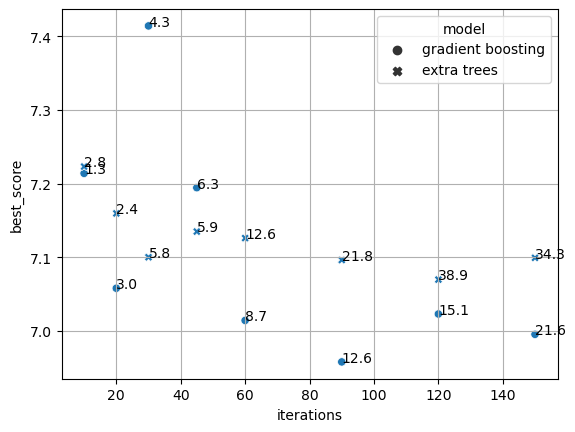

In [80]:
sns.scatterplot(it_search, x='iterations', y='best_score', style='model')
for val in it_search.index:
    plt.annotate(round(it_search.loc[val,'total_time']/60,1),
                 (it_search.loc[val,'iterations'], it_search.loc[val,'best_score']))
plt.grid()
plt.show()

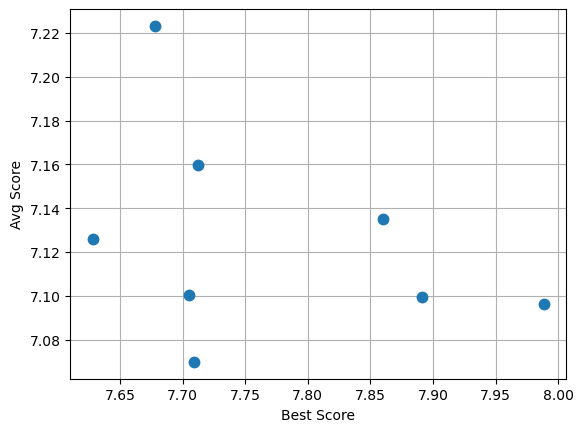

In [82]:
plt.plot(it_search.avg_score, it_search.best_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')

plt.xlabel('Best Score')
plt.ylabel('Avg Score')
plt.grid()
#plt.xlim(20,320)
plt.show()

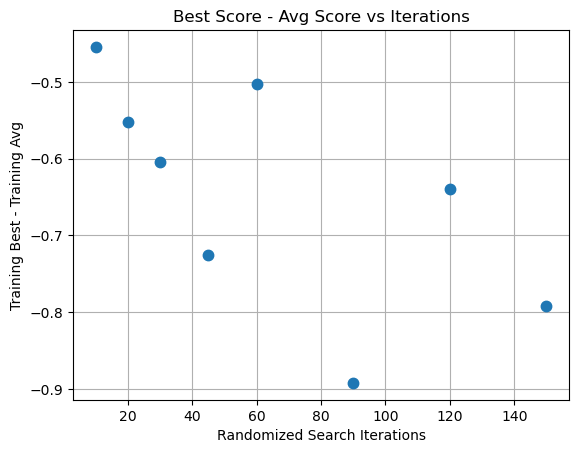

In [75]:
plt.plot(it_search.iterations, it_search.best_score - it_search.avg_score, '.', markersize=15)
#plt.errorbar(it_search.iterations, it_search.best_score - it_search.avg_score, yerr=it_search['std'], linestyle='')
plt.title('Best Score - Avg Score vs Iterations')
plt.xlabel('Randomized Search Iterations')
plt.ylabel('Training Best - Training Avg')
plt.grid()
#plt.xlim(20,320)
plt.show()

In [81]:
def ensemble_model_scoring(name, model, parameters):
    start = time()
    
    # fit model without tuning for a baseline score
    cv = cross_validate(model, X_train, y1_train, scoring='neg_mean_squared_error')
    model_scores.loc[name,'default_score'] = -1*cv['test_score'].mean()
   
    # setup RandomSearch for tuning
    clf = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_iter=20)
    
    # SelectKBest for linear regression models, perform search, score tuned model with test set
    search = clf.fit(X_train,y1_train)

    # save RandomSearch CV results
    model_scores.loc[name, 'best_train'] = -1*search.best_score_
    model_scores.loc[name, 'test_score'] = -1*search.score(X_test,y1_test)
    model_scores.loc[name, 'train_score_mean'] = -1*np.mean(search.cv_results_['mean_test_score'])
    model_scores.loc[name, 'train_score_std'] = np.mean(search.cv_results_['std_test_score'])   
    model_scores.loc[name, 'time'] = round(time()-start,2)
    model_scores.loc[name, 'best_params'] = str(search.best_params_)

In [ ]:
# model_scores = pd.DataFrame()

In [122]:
%%time
for name,model in def_models.items():
    ensemble_model_scoring(name,model, parameters[name])

CPU times: total: 7min 8s
Wall time: 7min 8s


In [123]:
model_scores.round(2)

,default_score,best_train,test_score,train_score_mean,train_score_std,time,best_params
Ridge,7.94,7.94,11.37,8.64,1.45,1.58,"{'alpha': 0.5053866139904047, 'solver': 'svd',..."
SGD,7.95,8.01,11.63,11.31,2.09,2.30,"{'alpha': 0.010777388620322096, 'learning_rate..."
gradient boosting,7.79,7.06,9.50,10.10,1.89,428.95,"{'learning_rate': 0.15795261968936813, 'n_esti..."
gradient boosting2,7.78,7.19,9.35,7.96,1.72,720.87,"{'learning_rate': 0.03856423787719148, 'n_esti..."


In [124]:
for ind in model_scores.index:
    print(ind, model_scores.loc[ind,'best_params'])

Ridge {'alpha': 0.5053866139904047, 'solver': 'svd', 'tol': 0.07828917070180205}
SGD {'alpha': 0.010777388620322096, 'learning_rate': 'adaptive', 'tol': 0.431041536295597}
gradient boosting {'learning_rate': 0.15795261968936813, 'n_estimators': 187}
gradient boosting2 {'learning_rate': 0.03856423787719148, 'n_estimators': 893}


In [125]:
1e-2

0.01

#### Best Parameters (delete later)


```
Ridge {'alpha': 0.044197503413627, 'solver': 'saga', 'tol': 0.013849922330190568}`
gradient boosting {'learning_rate': 0.05220115825458847, 'n_estimators': 412}
# estimators boltzmann(1e-3,1e3) and 'learning_rate':loguniform(1e-2,1e2)
```

 *second round*
 ```
Ridge {'alpha': 0.5053866139904047, 'solver': 'svd', 'tol': 0.07828917070180205}
SGD {'alpha': 0.010777388620322096, 'learning_rate': 'adaptive', 'tol': 0.431041536295597}
gradient boosting {'learning_rate': 0.07506576463273658, 'n_estimators': 432}
# estimators boltzmann(1e-4,1e3) and {'learning_rate':loguniform(3e-2,1e-1),
gradient boosting {'learning_rate': 0.15795261968936813, 'n_estimators': 187}
# estimators: boltzmann(3e-3,1e3) and 'learning_rate':loguniform(1e-2,5e-1)
```
recommend first or last set. last set fastest, first set has number of failed runs

### Final Exercise
 - score models again
   - default CV score (no tuning)
   - test score from default model
   - tuned score (RandomizedSearchCV, determined # of iterations)
   - test score from tuned model
   - total time
 - **Results**
   - all models improved with training, at least in CV scores
   - **move forward with Ridge Regression and XGB with decision trees `gbtree`**
     - XGB with `gblinear` sometimes shows good performance, but seems finnicky
     - sklearn's `GradientBoostingRegressor` performance not worth the fit time, could assess overfitting in future
   - 

In [66]:
def_models = {
    'Ridge': Ridge(), # 2s
    'xgb_linear': xgb.XGBRegressor(booster="gblinear"), # 5s
    'xgb_tree': xgb.XGBRegressor(booster="gbtree"), # 15ss
    'gradient_boosting': GradientBoostingRegressor(), # 10 min
}

parameters = {
    # defaults: alpha=1 [0,inf) | tol=1e-4
    'Ridge': {'rscv_iterations':150, 'alpha':stats.loguniform(0.001,5050,0,1), 'tol':stats.loguniform(1e-4,1e0,0,1), 'solver':['saga']},
    
    #lambda (L2), L1 reg???
    # defaults: L2=0, updater=shotgun, feature_selector=cyclic
    'xgb_linear': {'rscv_iterations':60, 'lambda':stats.gamma(1,0,1)},
    
    # eta/learning_rate, gamma/min_split_loss, max_depth
    # defaults: eta=0.3, gamma=0, max_depth=6, 
    'xgb_tree': {'rscv_iterations':45, 'eta':stats.beta(3,6,0,1), 'gamma':stats.uniform(0,3), 'max_depth':stats.binom(4,0.5,2),},

    # defaults: loss=squared_error, learning_rate=0.1, n_estimators=100
    'gradient_boosting': {'rscv_iterations':60, 'learning_rate':stats.loguniform(1e-3,1e2,0,1),'n_estimators':stats.boltzmann(1e-2,500,1), 
                          'loss':['huber']} ,
}

In [67]:
def model_scoring(name, model, parameters):
    start = time()
    
    # Select 6/12 features for linear models
    if name in ['Ridge','xgb_linear']:
        K_Select = SelectKBest(f_regression,k=6)
        train_samples = K_Select.fit_transform(X_train,y1_train)
        test_samples = K_Select.transform(X_test)
    else:
        train_samples = X_train
        test_samples = X_test
    
    # fit model without tuning for a baseline score  
    cv = cross_validate(model, train_samples, y1_train, scoring='neg_root_mean_squared_error')
    model_scores.loc[name,'default_train'] = -1*cv['test_score'].mean()
    # default test
    model.fit(train_samples, y1_train)
    model_scores.loc[name,'default_test'] = np.sqrt(mean_squared_error(y1_test, model.predict(test_samples)))
    
    # setup RandomSearch for tuning
    its = parameters.pop('rscv_iterations')
    clf = RandomizedSearchCV(model, parameters, scoring='neg_root_mean_squared_error', n_iter=its)
    
    # SelectKBest for linear regression models, perform search, score tuned model with test set
    search = clf.fit(train_samples,y1_train)

    # save RandomSearch CV results
    model_scores.loc[name, 'best_train'] = -1*search.best_score_
    model_scores.loc[name, 'test_score'] = -1*search.score(test_samples,y1_test)
    
    # NA values for failed fits, drop na then take mean of top 5 scores
    if name == 'gradient_boosting':
        df = pd.DataFrame(search.cv_results_).dropna()
        df = df.sort_values('mean_test_score',ascending=False).head()
        model_scores.loc[name, 'train_score_mean'] = -1*df['mean_test_score'].mean()
        model_scores.loc[name, 'train_score_mean'] = df['std_test_score'].mean()
    else:
        model_scores.loc[name, 'train_score_mean'] = -1*np.mean(search.cv_results_['mean_test_score'])
        model_scores.loc[name, 'train_score_std'] = np.mean(search.cv_results_['std_test_score'])   
    model_scores.loc[name, 'time'] = round(time()-start,2)
    model_scores.loc[name, 'best_params'] = str(search.best_params_)

In [68]:
model_scores = pd.DataFrame()

In [69]:
%%time
for name,model in tqdm(def_models.items()):
    model_scoring(name,model, parameters[name])

 75%|███████▌  | 3/4 [00:23<00:09,  9.40s/it]C:\Users\Nish\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow encountered in multiply
  gamma
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow encountered in multiply
  gamma
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow encountered in multiply
  gamma
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow encountered in multiply
  gamma
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow encountered in multiply
  gamma
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:434: RuntimeWarning: overflow

CPU times: total: 7min 52s
Wall time: 4min 10s


In [70]:
model_scores.round(3).sort_values('test_score')

,default_train,default_test,best_train,test_score,train_score_mean,train_score_std,time,best_params
gradient_boosting,2.801,2.658,2.707,2.640,0.311,NaN,226.97,"{'learning_rate': 0.08585917808872634, 'loss':..."
xgb_tree,2.880,2.997,2.739,2.704,2.853,0.336,15.90,"{'eta': 0.2501922039660882, 'gamma': 2.8059466..."
Ridge,2.980,2.976,2.973,2.980,3.241,0.455,2.46,"{'alpha': 6.303534337840651, 'solver': 'saga',..."
xgb_linear,2.971,2.987,2.981,3.011,3.919,0.332,4.96,{'lambda': 0.017268727359120623}


In [73]:
for model_name in def_models.keys():
    print(model_name,'|', model_scores['best_params'][model_name])

Ridge | {'alpha': 6.303534337840651, 'solver': 'saga', 'tol': 0.0002651451954540625}
xgb_linear | {'lambda': 0.017268727359120623}
xgb_tree | {'eta': 0.2501922039660882, 'gamma': 2.8059466261513193, 'max_depth': 4}
gradient_boosting | {'learning_rate': 0.08585917808872634, 'loss': 'huber', 'n_estimators': 196}


### Residuals Analysis
*Models trained on entire dataset, using best_params from RandomSearch.* 

##### XGB Tree

In [42]:
samples = scaler.fit_transform(X)

model = xgb.XGBRegressor(booster="gbtree", eta=0.2501922039660882, gamma=2.8059466261513193, max_depth=4)
model.fit(samples, y1)

y1_pred = model.predict(samples)

residuals = np.abs(y1 - y1_pred)
raw_resid = y1-y1_pred

data['predicted_margin'] = pd.Series(y1_pred,index=y1.index)
data['residuals'] = residuals

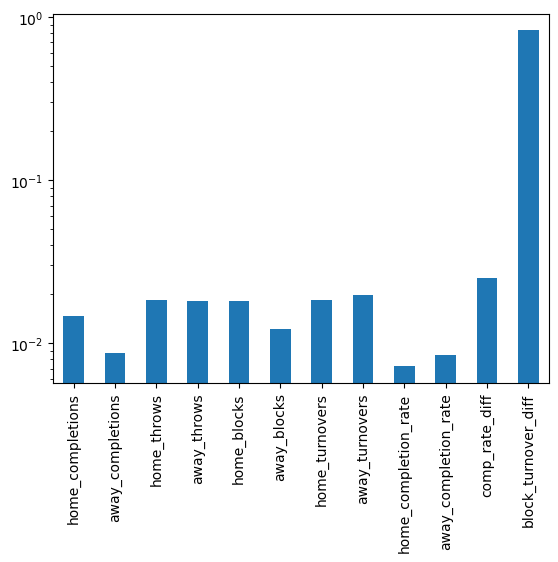

In [49]:
pd.Series(model.feature_importances_, index=features).plot(kind='bar')
plt.yscale('log')

In [23]:
data.sort_values('residuals',ascending=False).head().T

,2964,1923,2127,1974,2042
game,2022-11-12-allstar-game,2012-06-09-ROC-PHS,2014-06-07-DET-CHI,2013-05-03-MIN-MAD,2013-07-06-DC-NJH
date,2022-11-12 16:00:00+00:00,2012-06-09 19:00:00+00:00,2014-06-07 19:00:00+00:00,2013-05-03 20:00:00+00:00,2013-07-06 19:00:00+00:00
home,SW All-Stars,Spinners,Union,Radicals,Hammerheads
away,EC All-Stars,Dragons,Mechanix,Wind Chill,Breeze
home_score,24,33,26,19,17
away_score,42,16,13,15,24
home_completions,264,163,212,252,164
away_completions,241,172,264,221,266
home_throws,294,186,239,275,181
away_throws,262,184,296,235,283


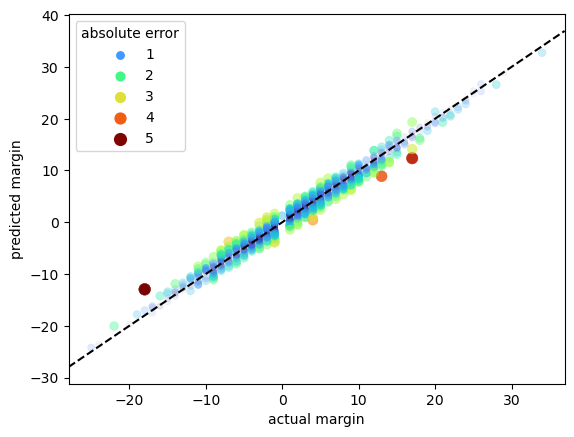

In [25]:
sns.scatterplot(x=y1, y=y1_pred, hue=residuals, 
                palette='turbo', edgecolor='face',
                size=residuals, alpha=residuals/residuals.max())
xlim = plt.xlim()
plt.plot(xlim,xlim, 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('predicted margin')
plt.xlabel('actual margin')
plt.show()

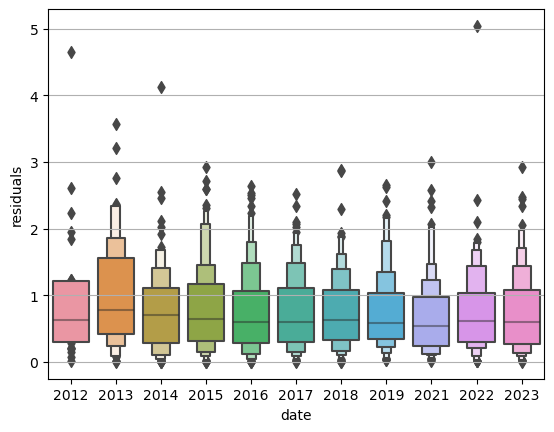

In [77]:
sns.boxenplot(data, y='residuals', x=data.date.dt.year)
plt.grid(axis='y')
plt.show()

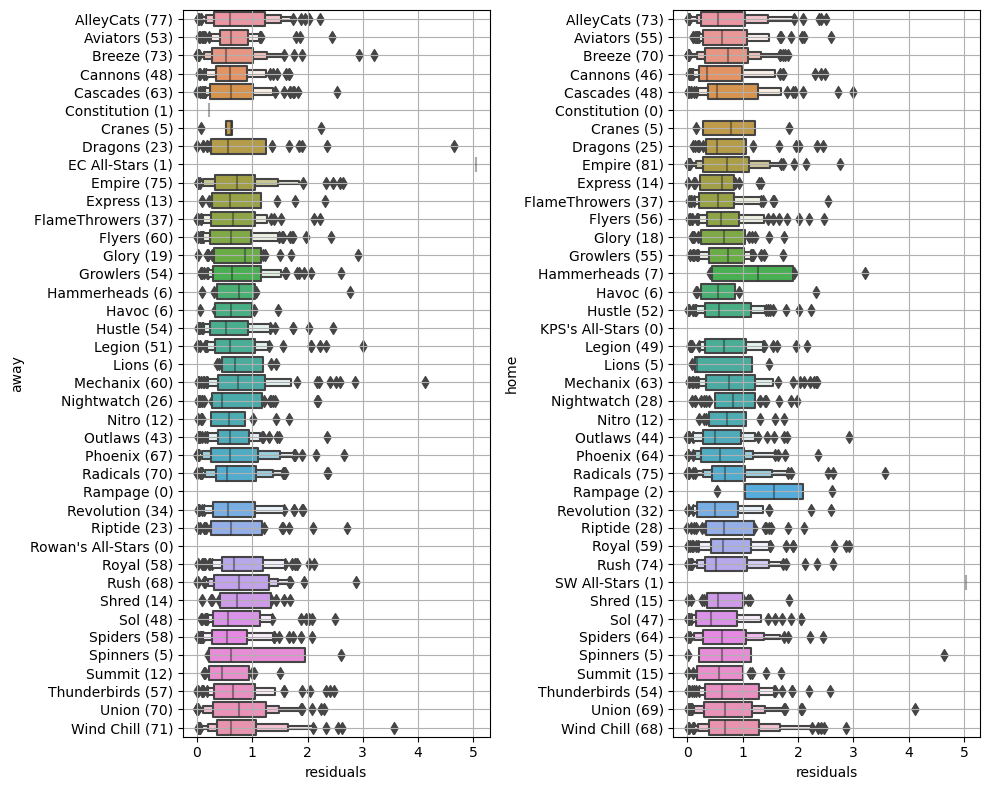

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

sns.boxenplot(data, x='residuals', y='away', ax=ax1)
ax1.grid()
ticks = ax1.get_yticks()
ax1.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('away').sort_index().items()]
          )

sns.boxenplot(data, x='residuals', y='home', ax=ax2)
ax2.grid()
ticks = ax2.get_yticks()
ax2.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('home').sort_index().items()]
          )

#fig['figsize'] = (12,10)
plt.show()

##### Ridge Regression

In [6]:
samples = scaler.fit_transform(X)

K_Select = SelectKBest(f_regression,k=6)
samples = K_Select.fit_transform(samples,y1)

model = Ridge(alpha=6.303534337840651,solver='saga',tol= 0.0002651451954540625)
model.fit(samples, y1)

y1_pred = model.predict(samples)

In [7]:
residuals = np.abs(y1 - y1_pred)
raw_resid = y1-y1_pred

data['predicted_margin'] = pd.Series(y1_pred,index=y1.index)
data['residuals'] = residuals

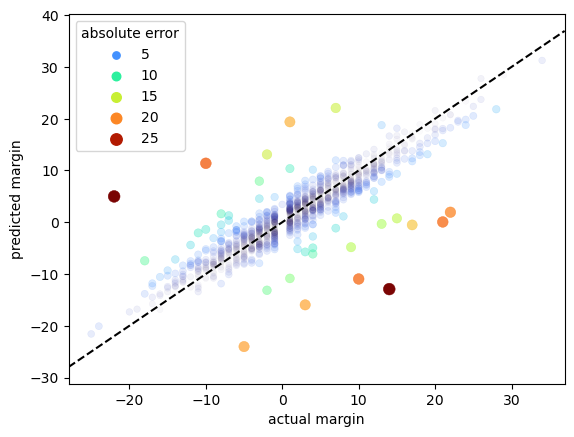

In [82]:
sns.scatterplot(x=y1, y=y1_pred, hue=residuals, 
                palette='turbo', edgecolor='face',
                size=residuals, alpha=residuals/residuals.max())
xlim = plt.xlim()
plt.plot(xlim,xlim, 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('predicted margin')
plt.xlabel('actual margin')
plt.show()

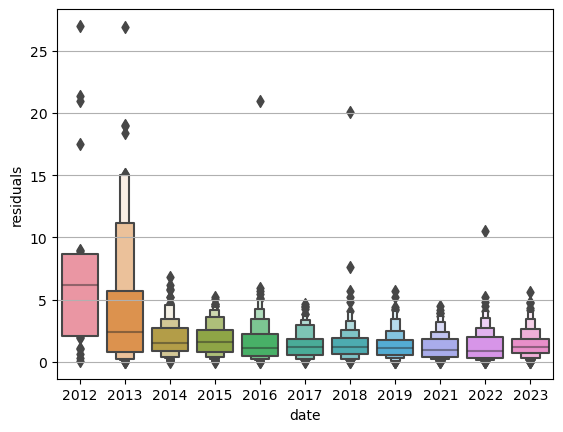

In [83]:
sns.boxenplot(data, y='residuals', x=data.date.dt.year)
plt.grid(axis='y')
plt.show()

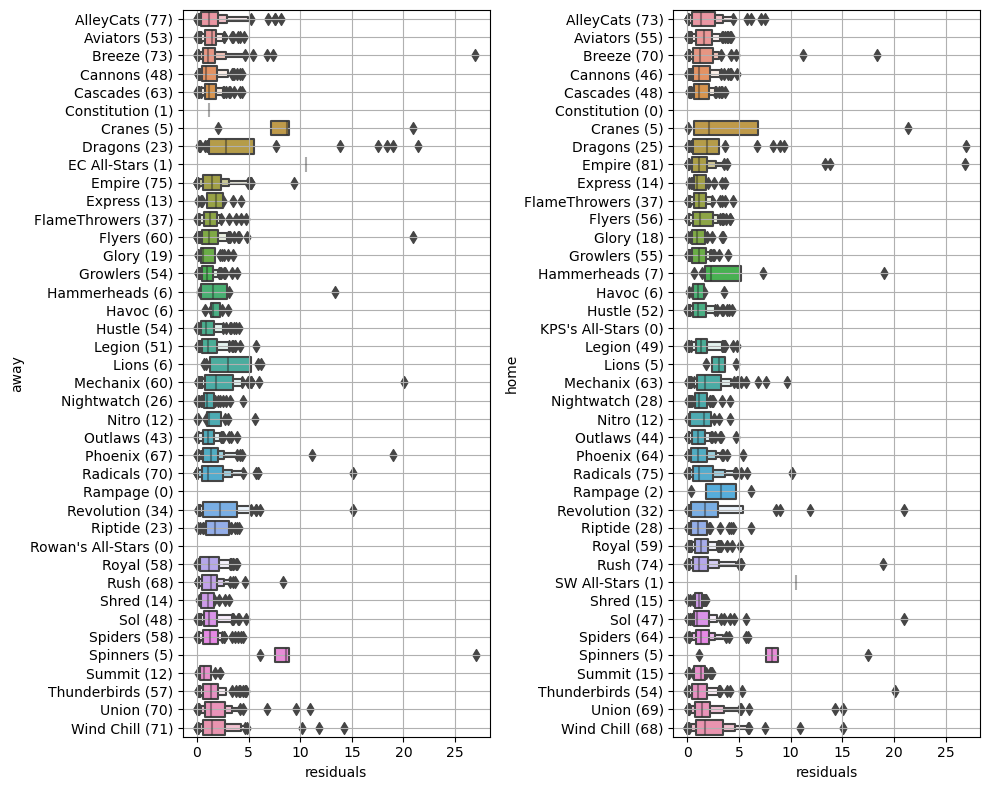

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

sns.boxenplot(data, x='residuals', y='away', ax=ax1)
ax1.grid()
ticks = ax1.get_yticks()
ax1.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('away').sort_index().items()]
          )

sns.boxenplot(data, x='residuals', y='home', ax=ax2)
ax2.grid()
ticks = ax2.get_yticks()
ax2.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('home').sort_index().items()]
          )

#fig['figsize'] = (12,10)
plt.show()

In [11]:
data.sort_values('residuals',ascending=False).head().T

,1943,1977,1940,1935,1525
game,2012-07-08-PHS-ROC,2013-05-04-DC-NY,2012-07-07-ROC-CLB,2012-06-30-CLB-CIN,2016-07-10-RAL-AUS
date,2012-07-08 19:00:00+00:00,2013-05-04 17:00:00+00:00,2012-07-07 19:00:00+00:00,2012-06-30 19:00:00+00:00,2016-07-10 12:30:00+00:00
home,Dragons,Empire,Cranes,Revolution,Sol
away,Spinners,Breeze,Dragons,Cranes,Flyers
home_score,13,25,0,10,33
away_score,35,11,10,0,12
home_completions,132,246,100,181,267
away_completions,167,268,173,119,104
home_throws,144,267,109,195,296
away_throws,193,268,187,132,125


In [283]:
data[(data.home=='Spinners') | (data.away=='Spinners')].T

,1893,1897,1900,1917,1923,1931,1943,1945,1947,1955
game,2012-04-14-ROC-PHS,2012-04-21-CON-PHS,2012-04-28-PHS-RIR,2012-05-27-CLB-PHS,2012-06-09-ROC-PHS,2012-06-23-PHS-ROC,2012-07-08-PHS-ROC,2012-07-14-PHS-IND,2012-07-15-PHS-CIN,2012-08-11-IND-PHS
date,2012-04-14 19:00:00+00:00,2012-04-21 19:00:00+00:00,2012-04-28 19:00:00+00:00,2012-05-27 19:00:00+00:00,2012-06-09 19:00:00+00:00,2012-06-23 19:00:00+00:00,2012-07-08 19:00:00+00:00,2012-07-14 19:00:00+00:00,2012-07-15 19:00:00+00:00,2012-08-11 19:00:00+00:00
home,Spinners,Spinners,Rampage,Spinners,Spinners,Dragons,Dragons,AlleyCats,Revolution,Spinners
away,Dragons,Constitution,Spinners,Cranes,Dragons,Spinners,Spinners,Spinners,Spinners,AlleyCats
home_score,26,22,22,23,33,18,13,16,17,29
away_score,14,16,30,20,16,29,35,19,27,22
home_completions,189,127,191,150,163,161,132,121,151,132
away_completions,180,197,182,99,172,171,167,153,141,110
home_throws,211,142,204,172,186,168,144,134,152,150
away_throws,190,203,205,112,184,191,193,174,158,118
